# Forcasting Closing Stock Price With Sentiment Analysis

SCS3546 Term Project

Due: April 6, 2021

Student: Michelle Lai

**Project Idea and Why it is Important**

With trillions of dollars in the stock market and countless variables impacting its trends, being able to accurately forecast stock prices is a profoundly complex and important task. Although classical financial theory suggest that financial investors base their decisions on rational analysis of available data, extensive studies have long revealed the significant influence of emotions leading to optimistic (bullish/positive) or pessimistic (bearish/negative) sentiment impacting investment decisions. 

For my term project I would like to **build/utilize a sequential neural network model combined with sentiment analysis data produced through the implementation of a natural language processing (NLP) model to try and forecast Apple Inc. (with AAPL stock ticker) closing (end-of-the-trading-day) prices.**  

Period of interest = **March 26, 2016 to March 26, 2021**

### Workflow

1. Import CSV of AAPL's historical transaction data within the period of interest to predict closing price.
2. Collect all available tweets (from twitter.com) containing "AAPL" for every day within the period of interest (1,852 days).
3. Implement transfer learning to utilize FinBERT pre-trained NLP model to analyze sentiment of tweets.
4. Collect sentiment data for each trading day.  
5. Concatenate sentiment score data to AAPL's historical transaction data. 
6. Build and tune long short-term memory (LSTM) network model to learn AAPL's historical transaction data (as a baseline to compare with an LSTM model with sentiment analysis) 
7. Build and tune an LSTM model on AAPL's historical transaction data combined with sentiment data to predict AAPL stock prices. 
8. Compare mean absolute error (MAE) between the two LSTM models (with and without sentiment analysis data)

Visual simplification of building LSTM model with sentiment analysis:

<img src="https://dfzljdn9uc3pi.cloudfront.net/2021/cs-408/1/fig-8-1x.jpg">

Source: [LSTM-based sentiment analysis for stock price forecast](https://peerj.com/articles/cs-408/) published on March 11, 2021.

### Goal: **Determine if it is better or not to utilize sentiment analysis data in predicting stock prices using Apple Inc.'s stocks as an example.**

---

**Import Modules**

In [1]:
#Import modules needed for math and managing dataframes
import numpy as np 
import pandas as pd 
from math import pi,sqrt,exp,pow,log
from numpy import newaxis
from scipy.stats import zscore

#Import modules for plotting
import matplotlib.pyplot as plt 
from matplotlib.ticker import MultipleLocator

#Import modules to build and train neural network
import tensorflow as tf
import keras
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
#from keras import metrics

#Import necessary modules for retrieving text data
from pymongo import MongoClient

# A Python library that offers a sensibleapproach to creating, 
# manipulating, formatting and converting dates, times and timestamps.
# Used to ensure correct time and gather text data related to trading day.
import arrow
from arrow import Arrow
from datetime import datetime, time
from dateutil import tz, parser

# To utilize pre-trained FinBERT model to retrieve sentiment scores on text data 
from finbert.finbert import predict
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from finbert.finbert import *
import finbert.utils as tools

#To monitor the completion of loops
from tqdm import tqdm


# **Data Preparation**
---
## Stock Historical Data

***1. Import CSV of AAPL's historical transaction data within the period of interest to predict closing price.***

The stock data is derived from a dataset posted [here](https://www.kaggle.com/paultimothymooney/stock-market-data). It includes the date, low, volume, open, high, close, and adjusted close of every trading day for AAPL from December 12, 1980 onward and is updated weekly.  

- Low indicates the lowest price that occured on that trading day.
- Open indicates the price at which the market opened with on that trading day (at 9:30 AM EST).
- Volume measures the number of shares traded in a stock or contracts traded in futures or options.
- High indicates the highest price that occured on that trading day.
- Close is the closing price is the raw price, which is just the cash value of the last transacted price before the market closes.
- Adjusted Close factors in anything that might affect the stock price after the market closes. A stock's price is typically affected by supply and demand of market participants. I will ignore this since I am taking account the sentiments after market close for the following trading day.

In [83]:
# Import the CSV file as a dataframe

df_AAPL = pd.read_csv('AAPL.csv')
df_AAPL.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,01-03-2016,24.355000,24.412500,201628400,25.192499,25.132500,23.375963
1,02-03-2016,24.910000,25.127501,132678400,25.222500,25.187500,23.427116
2,03-03-2016,25.112499,25.145000,147822800,25.427500,25.375000,23.601511
3,04-03-2016,25.342501,25.592501,184220400,25.937500,25.752501,23.952627
4,07-03-2016,25.240000,25.597500,143315600,25.707500,25.467501,23.687552


In [84]:
# I am only interested in the data available between March 26, 2016- March 26, 2021

start_date = '2016-03-25'
end_date = '2021-03-26'

In [85]:
# Update the dataframe to reflect the period of interest

df_AAPL['Date'] = pd.to_datetime(df_AAPL['Date'], dayfirst=True)  

df_AAPL = df_AAPL[df_AAPL['Date'].isin(pd.date_range(start_date, end_date))]

df_AAPL.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
18,2016-03-28,26.264999,26.5000,77645600,26.547501,26.297501,24.459534
19,2016-03-29,26.219999,26.2225,124760400,26.947500,26.920000,25.038527
20,2016-03-30,27.150000,27.1625,182404400,27.605000,27.389999,25.475679
21,2016-03-31,27.219999,27.4300,103553600,27.475000,27.247499,25.343138
22,2016-04-01,27.049999,27.1950,103496000,27.500000,27.497499,25.575666


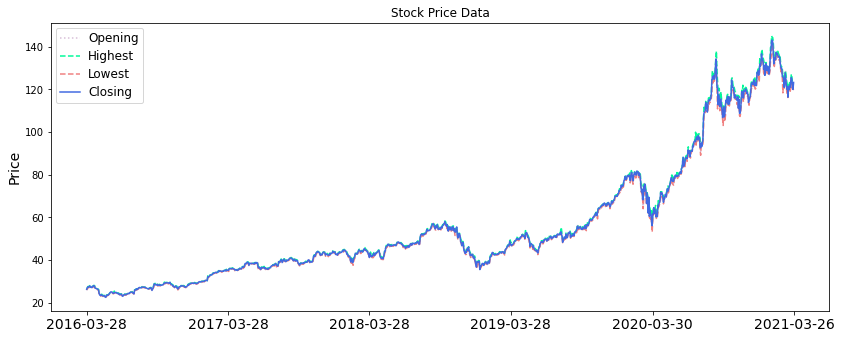

In [132]:
# Let's take a look at the stock historical data 
Hi_AAPL = np.array([df_AAPL.iloc[:,4]])
Low_AAPL = np.array([df_AAPL.iloc[:,1]])
Open_AAPL = np.array([df_AAPL.iloc[:,2]])
Close_AAPL = np.array([df_AAPL.iloc[:,5]])

Hi_AAPL = Hi_AAPL[0,:]
Low_AAPL = Low_AAPL[0,:]
Open_AAPL = Open_AAPL[0,:]
Close_AAPL = Close_AAPL[0,:]

# Initiate the figure and adjust the size
fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,1
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Stock Price Data')

# Plot the highest, lowest, and closing prices 
plt.plot(Open_AAPL,color="thistle",linestyle = ":",label="Opening",linewidth=1.5)
plt.plot(Hi_AAPL,color="mediumspringgreen",linestyle = "--",label="Highest",linewidth=1.5)
plt.plot(Low_AAPL,color="lightcoral",linestyle = "--",label="Lowest",linewidth=1.5)
plt.plot(Close_AAPL,color="royalblue",linestyle = "-",label="Closing",linewidth=1.5)

plt.ylabel("Price",fontsize=14)

# Include the legend
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

# Add human understandable days to the x-axis
x=np.array([0.,  251,  502, 753, 1005, 1256])
group_labels=['2016-03-28','2017-03-28','2018-03-28','2019-03-28', '2020-03-30','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

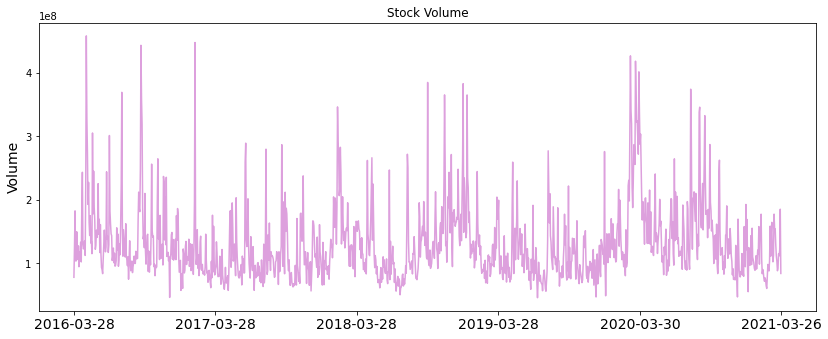

In [131]:
# Let's take a look at the volume

Vol_AAPL = np.array([df_AAPL.iloc[:,3]])

Vol_AAPL = Vol_AAPL[0,:]

# Initiate the figure and adjust the size
fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,1
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Stock Volume')

# Plot the highest, lowest, and closing prices 
plt.plot(Vol_AAPL,color="plum",linestyle = "-",linewidth=1.5)

plt.ylabel("Volume",fontsize=14)

# Include the legend
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

# Add human understandable days to the x-axis
x=np.array([0.,  251,  502, 753, 1005, 1256])
group_labels=['2016-03-28','2017-03-28','2018-03-28','2019-03-28', '2020-03-30','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

### Prepare the training, validation, and testing datasets for the **Baseline Model**

In [46]:
#Length of data frame (number of rows of data)
Len_AAPL = df_AAPL.shape[0]
print(Len_AAPL)

1256


In [47]:
#90% training 10% test dataset
split = (0.90);

# Focus on close prices only for the baseline model. 
cols = ['Close']

#Split the dataset
i_split = int(len(df_AAPL) * split)

#Get 10% test dataset
data_test  = df_AAPL.get(cols).values[i_split:]

#Get 90% train + validation datasets
data_train_valid = df_AAPL.get(cols).values[:i_split]
data_train_valid = pd.DataFrame(data_train_valid)

# Split train + validation datasets 90% and 10% respectively
i_split_2 = int(len(data_train_valid) * split)

data_train = data_train_valid.iloc[:i_split_2]
data_train = data_train.values
data_valid = data_train_valid.iloc[i_split_2:]
data_valid = data_valid.values

len_train  = len(data_train)
len_valid  = len(data_valid)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_valid.shape',data_valid.shape)
print('data_test.shape',data_test.shape)

data_train.shape (1017, 1)
data_valid.shape (113, 1)
data_test.shape (126, 1)


In [48]:
#Check data sets
data_train[0:5]

array([[26.29750061],
       [26.92000008],
       [27.38999939],
       [27.24749947],
       [27.49749947]])

In [49]:
data_valid[0:5]

array([[66.99749756],
       [68.3125    ],
       [71.76249695],
       [71.10749817],
       [71.67250061]])

In [50]:
data_test[0:5]

array([[110.0800018],
       [111.8099976],
       [107.1200027],
       [108.2200012],
       [112.2799988]])

**Further preprocessing and separating the datasets into x-train, y-train, x-validation, y-validation, x-test, and y-test datasets**

I want to predict the stock price of the next trading day based on historical data from the previous 10 days (a point-by-point prediction type).

The training window is initialized with all training data. Then the window is shifted and the next point is added to the last point of training window to predict the next point and so forth. 

According to the length of the window, the training data is divided into an appropriate number of sets of training input data (each set length 10) and training output data (each set length 1). The testing data is divided into input and output data of 9 windows.

In [51]:
# Getting the test dataset   

sequence_length=10;
data_windows = []
for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)

# get original y_test
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)


y_test_ori.shape (116, 1)


In [52]:
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

To detect stock price pattern, it is necessary to normalize the stock price data. Since the LSTM network model requires the stock patterns during training, we use min-max normalization to reform the dataset. This helps keep the pattern of the data.

In [53]:
# Normalize the dataset
normalise= True

for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

In [54]:
data_windows=normalised_data
x_test = data_windows[:, :-1]
y_test = data_windows[:, -1, [0]]
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

x_test.shape (116, 9, 1)
y_test.shape (116, 1)


In [55]:
#Check test dataset
x_test[0]

array([[0.30610131],
       [0.48500473],
       [0.        ],
       [0.11375374],
       [0.5336088 ],
       [0.81075469],
       [0.72078541],
       [0.89865528],
       [1.        ]])

In [56]:
y_test[0:5]

array([[0.61013392],
       [0.97001024],
       [0.62461242],
       [0.80046684],
       [0.59645258]])

In [57]:
# Getting the training dataset
data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)


In [58]:
data_windows=normalised_data
x_train = data_windows[:, :-1]
y_train = data_windows[:, -1,[0]]
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)

x_train.shape (1007, 9, 1)
y_train.shape (1007, 1)


In [59]:
# Check training dataset
x_train[0]

array([[0.        ],
       [0.41989844],
       [0.73693   ],
       [0.64080864],
       [0.80944269],
       [1.        ],
       [0.77908851],
       [0.97301793],
       [0.56492383]])

In [60]:
y_train[0:5]

array([[0.58516038],
       [0.38953354],
       [0.73643417],
       [1.        ],
       [1.        ]])

In [61]:
# Getting the validation dataset 
data_windows = []
for i in range(len_valid - sequence_length):
    data_windows.append(data_valid[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

In [62]:
# normalised_data=window_data
data_windows=normalised_data
x_valid = data_windows[:, :-1]
y_valid = data_windows[:, -1,[0]]
print('x_valid.shape',x_valid.shape)
print('y_valid.shape',y_valid.shape)

x_valid.shape (103, 9, 1)
y_valid.shape (103, 1)


In [63]:
#Check validation dataset
x_valid[0]

array([[0.        ],
       [0.27597117],
       [1.        ],
       [0.86253959],
       [0.98111304],
       [0.77701991],
       [0.46904531],
       [0.0199373 ],
       [0.42549931]])

In [64]:
y_valid[0:5]

array([[0.36936041],
       [0.78158522],
       [0.79229251],
       [0.55731372],
       [1.        ]])

Please note that I will be separating the dataframe containing sentiment analysis data in the same fashion as above. 

---
# Sentiment Analysis

Source: https://twitter.com/

***2. Collect all available tweets (posts made by users on Twitter) containing "AAPL" for every day within the period of interest (1,852 days).***

Utilizing SNS scrape, data was scraped using Twitter's search functionality on "**$AAPL**," Apple Inc.'s ticker.  

All tweets are time-stamped. Additionally, the NLP model I would like to implement is based in English, so only tweets in English are collected.

Now, let's import text data after scraping:

In [3]:
# Import text data and extract those within the relevant days 
c = MongoClient('mongodb://localhost:27017')
aapl_col = c['stock_scrape']['twitter_aapl']

# The time is in UTC, so it is -4 hours (in Summer) and -5 hours (in Winter) when converting to EST. 
# I use arrow to ensure the timezone and time of the day are correct and to implement a range of days of interest

earliest_date = arrow.get('2016-03-25 16:00:00').replace(tzinfo=tz.gettz('America/Toronto')).to('utc').datetime
recent_date = arrow.get('2021-03-26 15:45:00').replace(tzinfo=tz.gettz('America/Toronto')).to('utc').datetime

# Create a dataframe of available data between March 25, 2016 to March 26, 2021

df = pd.DataFrame(list(aapl_col.find({'date': {'$gte': earliest_date,'$lte': recent_date}})))
df.head()

,_id,conversationId,user,date,date_timestamp,content,renderedcontent,replyCount,retweetCount,likeCount,quoteCount,lang,source
0,605f20a81409dc21b7079a7d,713455561639989248,computer_hware,2016-03-25 20:00:35,1458936035,Tip: adjusting how movies and TV shows are sor...,Tip: adjusting how movies and TV shows are sor...,0,0,0,0,en,"<a href=""https://www.owler.com"" rel=""nofollow""..."
1,605f20a81409dc21b7079a7e,713455561619034113,_peripherals,2016-03-25 20:00:35,1458936035,Tip: adjusting how movies and TV shows are sor...,Tip: adjusting how movies and TV shows are sor...,0,0,0,0,en,"<a href=""https://www.owler.com"" rel=""nofollow""..."
2,605f20a81409dc21b7079a7b,713455716862799872,_peripherals,2016-03-25 20:01:12,1458936072,New #Apple Watch Bands Now Available for Perso...,New #Apple Watch Bands Now Available for Perso...,0,0,0,0,en,"<a href=""https://www.owler.com"" rel=""nofollow""..."
3,605f20a81409dc21b7079a7c,713455716854444032,computer_hware,2016-03-25 20:01:12,1458936072,New #Apple Watch Bands Now Available for Perso...,New #Apple Watch Bands Now Available for Perso...,0,0,0,0,en,"<a href=""https://www.owler.com"" rel=""nofollow""..."
4,605f20a81409dc21b7079a7a,713457227051311104,MacHashNews,2016-03-25 20:07:12,1458936432,Cost of out-of-warranty Apple Watch Sport repa...,Cost of out-of-warranty Apple Watch Sport repa...,0,0,1,0,en,"<a href=""https://dlvrit.com/"" rel=""nofollow"">d..."


In [4]:
df.count()

_id                1660166
conversationId     1660166
user               1660166
date               1660166
date_timestamp     1660166
content            1660166
renderedcontent    1660166
replyCount         1660166
retweetCount       1660166
likeCount          1660166
quoteCount         1660166
lang               1660166
source             1660166
dtype: int64

There are over 1.6 million separate tweets within the time rance of interest.

In [5]:
# Check the number of tweets per day
dates = df['date'].dt.date
df_counts_per_day = df.groupby([dates])['content'].count()
display(df_counts_per_day)
display(np.mean(df_counts_per_day))

date
2016-03-25     134
2016-03-26     395
2016-03-27     379
2016-03-28    1470
2016-03-29    1826
              ... 
2021-03-22    1650
2021-03-23    1283
2021-03-24    1288
2021-03-25    1374
2021-03-26    1093
Name: content, Length: 1828, dtype: int64

908.1870897155361

### Implementing the pre-trained NLP model FinBERT

Important points to note regarding the text data:
- Any tweets that occur between 4:00 PM UTC-4 (EST) and 11:59 PM EST on weekdays are considered within the post-market time. (Although, Nasdaq and New York Stock Exchange allows after-market trading from 4:00 to 8:00 PM EST there is generally much lower volume.)  As such, I will include the tweets generated after 4:00 PM to analyze sentiment for the next trading day.  
- I will filter out tweets generatated between 3:45 PM ETC and 4:00 PM ETC to see if the model can learn without it as it would become the time frame the user uses to buy or sell AAPL shares.  
- The stock market is closed on weekends.  
- There are certain observed holidays during which the market is closed. A list can be found [here](https://www.nyse.com/markets/hours-calendars)

All time related points noted here are addressed right before implementing the model.  

***3. Implement transfer learning to utilize FinBERT pre-trained NLP model to analyze sentiment of financial text.***


[FinBERT](https://github.com/ProsusAI/finBERT) is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification. ([FinBERT: Financial Sentiment Analysis with Pre-trained Language Models](https://arxiv.org/pdf/1908.10063.pdf))

The model will give softmax outputs for three labels - positive, negative or neutral - in addition to

<center> sentiment score = probability of positive - probability of negative </center>

Let's import FinBERT and try it out:

In [2]:
model = AutoModelForSequenceClassification.from_pretrained('models/financial', 
                                                           num_labels=3,
                                                           cache_dir=None).cuda()
tokenizer = AutoTokenizer.from_pretrained('models/financial')

In [21]:
#Example output 

example = '$AAPL shares recovered its losses by May, surpassed its previous all-time high earlier from February, and outperformed the market through the year as the company demonstrated its value and ability to overcome the disruptions of the pandemic.'

predict(example,model)

,sentence,logit,prediction,sentiment_score
0,"$AAPL shares recovered its losses by May, surp...","[0.9477309, 0.02838894, 0.023880115]",positive,0.919342


***4. Collect sentiment data for each trading day.*** 

The *following cell executes several functions*, so it is rather information heavy. As such, I would like to summarize here that it...
- **Produces each trading day**
    - Here, I will combine the text content based on the trading day (as mentioned earlier) since the FinBERT model is capable of running many sentences at a time and it will output a sentiment score per sentence.  This will speed up computing time for sentiment analysis (without implementing this, it would have taken more than a week to run).    
    - Each trading day -including Mondays - would have the text content for 
        - (20XX-XX-XX -1 20:00:00) to (20XX-XX-XX 19:45:00) in the Summer 
        - (20XX-XX-XX -1 21:00:00) to (20XX-XX-XX 20:45:00) in the Winter
    - Because the stock historical transaction data only contains trading days and I will merge sentiment data with that dataframe, all non-trading days (including holidays and weekends) will be ignored.  
    

- **Runs FinBERT sentiment analysis on every relevant comment per trading day**
    - FinBERT breaks down every input into sentences and outputs softmax scores for positive, negative, and neutral sentiment per sentence.  
    
    
- **Collects the sentiment scores data for each trading day and saves them in a csv file.**  
    - Resulting in a dataset containing the sentiment score mean, standard deviation, maximum, minimum, and median for each trading day.

In [14]:
# To get rid of emojis in every tweet 
import demoji
demoji.download_codes()

# A function that returns concatenated string of all tweets on that particular day

def get_content_for_day(date, content_df):
    
    # Tweets for a trading day include those of the previous day from 4:00 PM EST
    start_time = arrow\
        .get(date)\
        .shift(days=-1)\
        .shift(hours=16)\
        .replace(tzinfo=tz.gettz('America/Toronto'))\
        .to('utc').datetime
    
    # Tweets for a trading day is inclusive up until 3:45 PM EST on the current day
    end_time = arrow\
        .get(date)\
        .shift(hours=15, minutes=45)\
        .replace(tzinfo=tz.gettz('America/Toronto'))\
        .to('utc').datetime
    
    # Create a function to convert pandas and datetime time to computer time in seconds
    def compare_unix(x):
        # Unix time is in milliseconds 
        unix_x = x.value // 10 ** 9
        return unix_x >= start_time.timestamp() and unix_x <= end_time.timestamp()
    
    def process_content(x):
        # Replace newlines with period
        x = x.replace('\n', '.')
        # Remove emojis
        x = demoji.replace(x, '')
        
        # Make sure each tweet ends with period
        if x[-1] != '.':
            x = x + '.'
        return x
    
    day_df = content_df[content_df['date'].apply(compare_unix)].copy()
    
    # Transformations on content here
    day_df['content'] = day_df['content'].apply(process_content).copy()
    
    # Concatenate content per trading day
    content_string = ""
    for index, row in day_df.iterrows():
        content_string = content_string + " " + row['content']
    
    return {
        'Date': end_time.date(),
        'content': content_string
    }

# A function to extract relevant sentiment score data

def reduce_score(predictions_df):
    
    # Get rid of text content (sentences) that produce neutral predictions (they are more likely to be noise)
    predictions_df = predictions_df[predictions_df.prediction != 'neutral']

    if (len(predictions_df) == 0):
        return 0
    
    # To maximize sentiment scores, I gather several different metrics related to the sentiment analysis.
    return {
        # Take the average of each sentence's sentiment score.
        'mean': predictions_df['sentiment_score'].mean(),
        
        # Take the standard deviation of each sentence's sentiment score.
        'stan_dev':predictions_df['sentiment_score'].std(),
        
        # Take the minimum sentiment score measured in the alloted time frame
        'min':predictions_df['sentiment_score'].min(),
        
        # Take the maximum sentiment score measured in the alloted time frame
        'max':predictions_df['sentiment_score'].max(),
        
        # Take the median sentiment score measured in the alloted time frame
        'median':predictions_df['sentiment_score'].median()
    }

# A function to implement the pre-trained sentiment analysis model FinBERT to analyze every tweet
# and return relevant sentiment score data indicated in the reduce_score function
# (it separates each input into sentences and provides a sentiment score for each sentence)

def predict_sentiment_one_day(date, content_df, model):
    
    day_content = get_content_for_day(date, content_df)
    predictions = predict(day_content['content'], model)
    
    # Wrangle to add in date as primary key
    predictions['logit'] = predictions['logit'].apply(lambda x: x.tolist())
    
    # Function to reduce to one score
    score = reduce_score(predictions)
    return {
        'Date': day_content['Date'],
        'Sentiment_Mean': score['mean'],
        'Sentiment_SD': score['stan_dev'],
        'Sentiment_Min': score['min'],
        'Sentiment_Max': score['max'],
        'Sentiment_Median': score['median']
    }

# Shift one day forward since the first relevant trading day is March 26, 2016 
earliest_date_1 = arrow.get(earliest_date).shift(days=1).datetime

# Monitor progress with tqdm
pbar = tqdm(Arrow.range('day', earliest_date_1, recent_date))

# Create a dataframe to contain sentiment analysis for every trading day 
sentiment_df = pd.DataFrame([])

# Generate sentiment score for each trading day 
for day in pbar:
    sentiment = predict_sentiment_one_day(day.date(), df, model)
    sentiment_df = sentiment_df.append(sentiment, ignore_index=True)
    pbar.set_description(f'Processed {day} with sentiment {sentiment}')

# Save sentiment data into a csv file
sentiment_df.to_csv('sentiment_data_AAPL.csv', sep=',')

... OK (Got response in 0.29 seconds)
Writing emoji data to /home/jupyter-michelle/.demoji/codes.json ...
... OK


Processed 2020-10-27T20:00:00+00:00 with sentiment {'Date': datetime.date(2020, 10, 27), 'Sentiment_Mean': 0.08893381, 'Sentiment_SD': 0.72075343, 'Sentiment_Min': -0.9651397, 'Sentiment_Max': 0.93793136, 'Sentiment_Median': 0.4546905}: : 1677it [5:53:15, 14.78s/it]     Token indices sequence length is longer than the specified maximum sequence length for this model (1349 > 512). Running this sequence through the model will result in indexing errors
Processed 2021-03-25T20:00:00+00:00 with sentiment {'Date': datetime.date(2021, 3, 25), 'Sentiment_Mean': -0.06544403, 'Sentiment_SD': 0.73751783, 'Sentiment_Min': -0.9677156, 'Sentiment_Max': 0.9317194, 'Sentiment_Median': -0.3357249}: : 1826it [6:30:59, 12.85s/it]    


The warning for October 27, 2020 can be ignored as running the model did not crash and I am still recieving enough data as well as all other days' data. 

It took 6.5 hours to analyze the sentiment of every sentence from every tweet for each trading day.

In [15]:
# Check the sentiment analysis dataframe
sentiment_df

,Date,Sentiment_Max,Sentiment_Mean,Sentiment_Median,Sentiment_Min,Sentiment_SD
0,2016-03-26,0.929325,-0.081959,-0.496960,-0.945361,0.736744
1,2016-03-27,0.930243,-0.264029,-0.567708,-0.943159,0.678299
2,2016-03-28,0.934264,-0.252371,-0.640036,-0.966853,0.704132
3,2016-03-29,0.935424,-0.348033,-0.651760,-0.963378,0.648545
4,2016-03-30,0.938398,-0.105844,-0.507048,-0.966898,0.749487
...,...,...,...,...,...,...
1821,2021-03-21,0.932782,0.107866,0.510360,-0.964081,0.703867
1822,2021-03-22,0.933958,0.179656,0.543687,-0.967349,0.711438
1823,2021-03-23,0.934417,0.079043,0.473414,-0.966559,0.737455
1824,2021-03-24,0.929475,0.054266,0.470257,-0.964974,0.716979


In [6]:
#For easier access (if I restart the kernel) connect with csv file

sentiment_df_csv = pd.read_csv('sentiment_data_AAPL.csv')

sentiment_df_csv['Date'] = pd.to_datetime(sentiment_df_csv['Date'], dayfirst=True)  
sentiment_df_csv = sentiment_df_csv[sentiment_df_csv['Date'].isin(pd.date_range(start_date, end_date))]

sentiment_df_csv.head()

,Unnamed: 0,Date,Sentiment_Max,Sentiment_Mean,Sentiment_Median,Sentiment_Min,Sentiment_SD
0,0,2016-03-26,0.929325,-0.081959,-0.496960,-0.945361,0.736744
1,1,2016-03-27,0.930243,-0.264029,-0.567708,-0.943159,0.678299
2,2,2016-03-28,0.934264,-0.252371,-0.640036,-0.966853,0.704132
3,3,2016-03-29,0.935424,-0.348033,-0.651760,-0.963378,0.648545
4,4,2016-03-30,0.938398,-0.105844,-0.507048,-0.966898,0.749487


In [92]:
# Check the shape
sentiment_df_csv.shape

(1826, 7)

Notice that there are more days in this dataframe than for the stock historical transaction's dataframe. This would be addressed when I merge the dataframes by date later.  

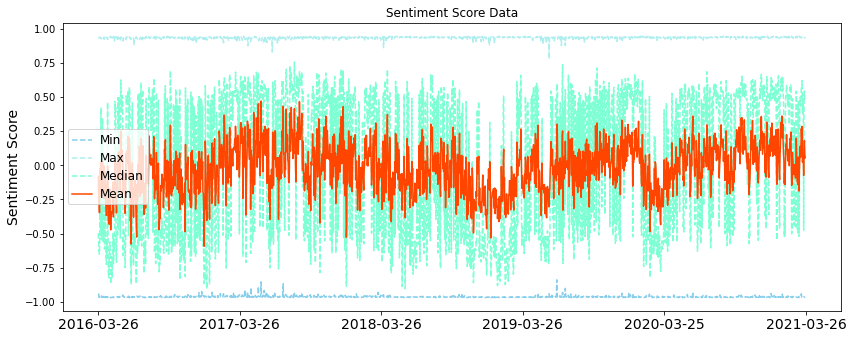

In [130]:
# Let's take a look at the sentiment data

mean_plot = sentiment_df_csv['Sentiment_Mean'][0:sentiment_df_csv.shape[0]-1]
min_plot = sentiment_df_csv['Sentiment_Min'][0:sentiment_df_csv.shape[0]-1]
max_plot = sentiment_df_csv['Sentiment_Max'][0:sentiment_df_csv.shape[0]-1]
med_plot = sentiment_df_csv['Sentiment_Median'][0:sentiment_df_csv.shape[0]-1]
SD_plot = sentiment_df_csv['Sentiment_SD'][0:sentiment_df_csv.shape[0]-1]

# Initiate the figure and adjust the size
fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,1
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Sentiment Score Data')

# Plot mean, min, max, and median values
plt.plot(min_plot,color="skyblue",linestyle = "--",label="Min",linewidth=1.5)
plt.plot(max_plot,color="paleturquoise",linestyle = "--",label="Max",linewidth=1.5)
plt.plot(med_plot,color="aquamarine",linestyle = "--",label="Median",linewidth=1.5)
plt.plot(mean_plot,color="orangered",linestyle = "-",label="Mean",linewidth=1.5)
#plt.plot(SD_plot,color="aquamarine",linestyle = ":",label="Standard Deviation",linewidth=1.5)

plt.ylabel("Sentiment Score",fontsize=14)

# Include the legend
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

# Add human understandable days
x=np.array([0.,  365, 730, 1095, 1460, 1826])
group_labels=['2016-03-26','2017-03-26','2018-03-26','2019-03-26', '2020-03-25','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

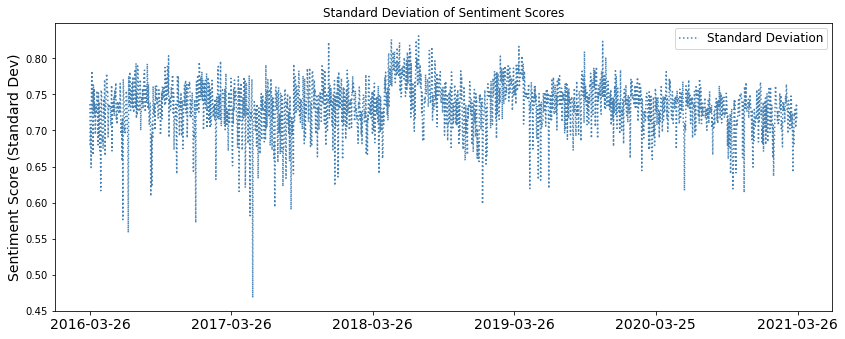

In [135]:
# Plot the standard deviations of the sentiment scores

fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,1
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Standard Deviation of Sentiment Scores')

plt.plot(SD_plot,color="steelblue",linestyle = ":",label="Standard Deviation",linewidth=1.5)

plt.ylabel("Sentiment Score (Standard Dev)",fontsize=14)
   
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

x=np.array([0.,  365, 730, 1095, 1460, 1826])
group_labels=['2016-03-26','2017-03-26','2018-03-26','2019-03-26', '2020-03-25','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

The standard deviation is a measure of the amount of variation or dispersion of a set of values. A large standard deviation indicates that the data points spread far from the mean and a small one indicates the data points cluster close to the mean.  In this case, we generally have large standard deviation values. It does seem to vary between a large range as well, as such I will include this information for training the model.

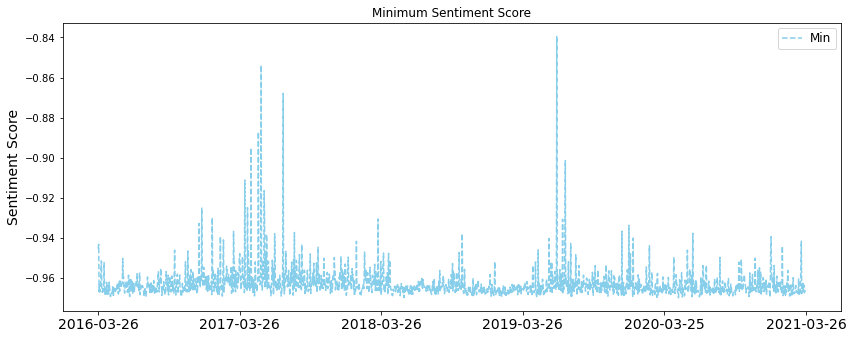

In [134]:
# Plot the minimum sentiment scores

fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,1
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Minimum Sentiment Score')

plt.plot(min_plot,color="skyblue",linestyle = "--",label="Min",linewidth=1.5)

plt.ylabel("Sentiment Score",fontsize=14)
   
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

x=np.array([0.,  365, 730, 1095, 1460, 1826])
group_labels=['2016-03-26','2017-03-26','2018-03-26','2019-03-26', '2020-03-25','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

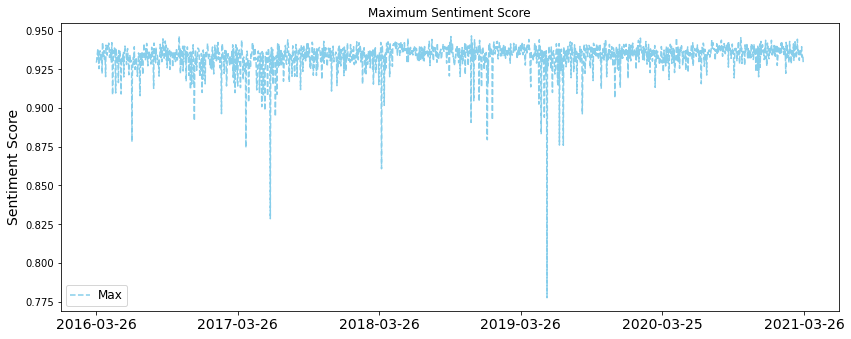

In [136]:
# Plot the maximum sentiment scores

fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,1
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Maximum Sentiment Score')

plt.plot(max_plot,color="skyblue",linestyle = "--",label="Max",linewidth=1.5)

plt.ylabel("Sentiment Score",fontsize=14)
   
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

x=np.array([0.,  365, 730, 1095, 1460, 1826])
group_labels=['2016-03-26','2017-03-26','2018-03-26','2019-03-26', '2020-03-25','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

The minimum and maximum sentiment scores seems to rarely indicate something special on the trading day (these values seem to mainly hover between a small range).  Additionally, I tested training with these values and the performance of the model decreased, so I will leave them out of training for the final model. 

Checking the news regarding Apple Inc. from days with more skewed mean sentiment scores (towards positive or negative), I found that the data seems to corroborate with the news type. For example, on March 29, 2016 with an average sentiment score of -0.38 the news showed an ongoing [dispute with the FBI involving a terrorist](https://www.cnbc.com/2016/03/29/apple-vs-fbi-all-you-need-to-know.html). On May 13, 2017, the average sentiment score was 0.45 and news had broken out about their [acquirement of a data mining and machine learning company](https://fortune.com/2017/05/13/apple-lattice/).  

### Merge stock historical data with sentiment analysis data 

***5. Concatenate sentiment score to AAPL's historical transaction data.***

In [10]:
print('stock date data is in dtype: '+ str(df_AAPL['Date'].dtype))
print('sentiment date data is in dtype: '+ str(sentiment_df_csv['Date'].dtype))

stock date data is in dtype: datetime64[ns]
sentiment date data is in dtype: datetime64[ns]


In [11]:
sentiment_df_AAPL = pd.merge(df_AAPL, sentiment_df_csv, on='Date')
sentiment_df_AAPL.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close,Unnamed: 0,Sentiment_Max,Sentiment_Mean,Sentiment_Median,Sentiment_Min,Sentiment_SD
0,2016-03-28,26.264999,26.5000,77645600,26.547501,26.297501,24.459534,2,0.934264,-0.252371,-0.640036,-0.966853,0.704132
1,2016-03-29,26.219999,26.2225,124760400,26.947500,26.920000,25.038527,3,0.935424,-0.348033,-0.651760,-0.963378,0.648545
2,2016-03-30,27.150000,27.1625,182404400,27.605000,27.389999,25.475679,4,0.938398,-0.105844,-0.507048,-0.966898,0.749487
3,2016-03-31,27.219999,27.4300,103553600,27.475000,27.247499,25.343138,5,0.931543,-0.021930,0.012816,-0.964766,0.782596
4,2016-04-01,27.049999,27.1950,103496000,27.500000,27.497499,25.575666,6,0.934028,-0.110605,-0.480215,-0.964599,0.724870


### Prepare the training, validation, and testing datasets for the **Model With Sentiment Analysis**

In [131]:
# Length of dataset
len_dataframe=sentiment_df_AAPL.shape[0]
print(len_dataframe)

1256


In [114]:
# 90% training 10% test dataset
split = (0.90);

# Columns interested in (found that these features yielded the best performance):
cols = ['Close','Sentiment_Mean',
        'Sentiment_Median','Sentiment_SD']

# Split the dataset
i_split = int(len(sentiment_df_AAPL) * split)

# Get 10% test dataset
data_test  = sentiment_df_AAPL.get(cols).values[i_split:]

# Get 90% train + validation datasets
data_train_valid = sentiment_df_AAPL.get(cols).values[:i_split]
data_train_valid = pd.DataFrame(data_train_valid)

# Split train + validation datasets 90% and 10% respectively
i_split_2 = int(len(data_train_valid) * split)

data_train = data_train_valid.iloc[:i_split_2]
data_train = data_train.values
data_valid = data_train_valid.iloc[i_split_2:]
data_valid = data_valid.values

len_train  = len(data_train)
len_valid  = len(data_valid)
len_test   = len(data_test)
len_train_windows = None
print('data_train.shape',data_train.shape)
print('data_valid.shape',data_valid.shape)
print('data_test.shape',data_test.shape)

data_train.shape (1017, 4)
data_valid.shape (113, 4)
data_test.shape (126, 4)


In [115]:
# Check data sets
data_train[0:5]

array([[ 2.62975006e+01, -2.52371401e-01, -6.40035570e-01,
         7.04132318e-01],
       [ 2.69200001e+01, -3.48032951e-01, -6.51759505e-01,
         6.48545086e-01],
       [ 2.73899994e+01, -1.05843991e-01, -5.07047653e-01,
         7.49487340e-01],
       [ 2.72474995e+01, -2.19295323e-02,  1.28162205e-02,
         7.82596469e-01],
       [ 2.74974995e+01, -1.10605277e-01, -4.80215490e-01,
         7.24869788e-01]])

In [116]:
data_test[0:5]

array([[ 1.10080002e+02, -1.25717968e-01, -4.70936269e-01,
         7.28504837e-01],
       [ 1.11809998e+02,  1.28099382e-01,  5.23066282e-01,
         7.23889887e-01],
       [ 1.07120003e+02, -5.69825480e-03,  3.47077906e-01,
         7.51726329e-01],
       [ 1.08220001e+02, -3.11576072e-02, -4.28016782e-02,
         7.39631772e-01],
       [ 1.12279999e+02,  5.37167229e-02,  4.78777677e-01,
         7.30426133e-01]])

In [117]:
data_valid[0:5]

array([[ 6.69974976e+01, -1.24852709e-01, -4.79759574e-01,
         7.49004960e-01],
       [ 6.83125000e+01, -2.80417576e-02,  7.62030184e-02,
         7.46588469e-01],
       [ 7.17624969e+01,  1.64063394e-01,  5.25889635e-01,
         7.14497447e-01],
       [ 7.11074982e+01,  8.55805576e-02,  4.89203900e-01,
         7.45678902e-01],
       [ 7.16725006e+01, -3.02071217e-02, -1.56490177e-01,
         7.34769046e-01]])

In [118]:
# Getting the test dataset

sequence_length=10;
data_windows = []

for i in range(len_test - sequence_length):
    data_windows.append(data_test[i:i+sequence_length])
    
data_windows = np.array(data_windows).astype(float)

# Get the original y_test to check shape
y_test_ori = data_windows[:, -1, [0]]
print('y_test_ori.shape',y_test_ori.shape)

window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]
normalised_data = []
record_min=[]
record_max=[]

y_test_ori.shape (116, 1)


In [119]:
# Normalize the data
normalise= True
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,1):#col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    for col_i in range(1,col_num):
      temp_col=window_data[win_i,:,col_i]
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

In [121]:
data_windows=normalised_data
x_test_s = data_windows[:, :-1]
y_test_s = data_windows[:, -1, [0]]
print('x_test_s.shape',x_test_s.shape)
print('y_test_s.shape',y_test_s.shape)

x_test_s.shape (116, 9, 4)
y_test_s.shape (116, 1)


In [122]:
#Check the test dataset
x_test_s[0]

array([[ 0.30610131, -0.12571797, -0.47093627,  0.72850484],
       [ 0.48500473,  0.12809938,  0.52306628,  0.72388989],
       [ 0.        , -0.00569825,  0.34707791,  0.75172633],
       [ 0.11375374, -0.03115761, -0.04280168,  0.73963177],
       [ 0.5336088 ,  0.05371672,  0.47877768,  0.73042613],
       [ 0.81075469,  0.25907218,  0.55782348,  0.66034228],
       [ 0.72078541,  0.17786513,  0.53158045,  0.69146472],
       [ 0.89865528,  0.15240096,  0.502702  ,  0.7133891 ],
       [ 1.        ,  0.23935586,  0.5442515 ,  0.67714584]])

In [123]:
y_test_s[0:5]

array([[0.61013392],
       [0.97001024],
       [0.62461242],
       [0.80046684],
       [0.59645258]])

In [124]:
# Getting the training dataset

data_windows = []
for i in range(len_train - sequence_length):
    data_windows.append(data_train[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []

for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,1):#col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      if col_i==0:
        record_min.append(temp_min)#record min
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      if col_i==0:
        record_max.append(temp_max)#record max
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    for col_i in range(1,col_num):
      temp_col=window_data[win_i,:,col_i]
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

In [125]:
data_windows=normalised_data
x_train_s = data_windows[:, :-1]
y_train_s = data_windows[:, -1,[0]]
print('x_train_s.shape',x_train_s.shape)
print('y_train_s.shape',y_train_s.shape)

x_train_s.shape (1007, 9, 4)
y_train_s.shape (1007, 1)


In [126]:
#Check the training dataset
x_train_s[0]

array([[ 0.        , -0.2523714 , -0.64003557,  0.70413232],
       [ 0.41989844, -0.34803295, -0.65175951,  0.64854509],
       [ 0.73693   , -0.10584399, -0.50704765,  0.74948734],
       [ 0.64080864, -0.02192953,  0.01281622,  0.78259647],
       [ 0.80944269, -0.11060528, -0.48021549,  0.72486979],
       [ 1.        ,  0.02479334,  0.30060661,  0.76419443],
       [ 0.77908851, -0.15642218, -0.49189848,  0.72784185],
       [ 0.97301793,  0.02207222,  0.34502769,  0.75797147],
       [ 0.56492383, -0.20327462, -0.55501336,  0.72060794]])

In [127]:
y_train_s[0:5]

array([[0.58516038],
       [0.38953354],
       [0.73643417],
       [1.        ],
       [1.        ]])

In [128]:
# Getting the validation data set 
data_windows = []
for i in range(len_valid - sequence_length):
    data_windows.append(data_valid[i:i+sequence_length])
data_windows = np.array(data_windows).astype(float)
  
window_data=data_windows
win_num=window_data.shape[0]
col_num=window_data.shape[2]

normalised_data = []
for win_i in range(0,win_num):
    normalised_window = []
    for col_i in range(0,col_num):
      temp_col=window_data[win_i,:,col_i]
      temp_min=min(temp_col)
      temp_col=temp_col-temp_min
      temp_max=max(temp_col)
      temp_col=temp_col/temp_max
      normalised_window.append(temp_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
normalised_data=np.array(normalised_data)

In [129]:
data_windows=normalised_data
x_valid_s = data_windows[:, :-1]
y_valid_s = data_windows[:, -1,[0]]
print('x_valid_s.shape',x_valid_s.shape)
print('y_valid_s.shape',y_valid_s.shape)

x_valid_s.shape (103, 9, 4)
y_valid_s.shape (103, 1)


In [30]:
# Check the validation dataset
x_valid_s[0]

array([[0.        , 0.2657735 , 0.07530785, 0.51455525],
       [0.27597117, 0.51180051, 0.58651418, 0.47852198],
       [1.        , 1.        , 1.        , 0.        ],
       [0.86253959, 0.80055048, 0.96626755, 0.46495907],
       [0.98111304, 0.50629764, 0.37255332, 0.30227788],
       [0.77701991, 0.        , 0.        , 0.15779463],
       [0.46904531, 0.32458603, 0.08093575, 0.59506082],
       [0.0199373 , 0.4994753 , 0.46474924, 1.        ],
       [0.42549931, 0.60199512, 0.81421614, 0.47699238]])

In [31]:
y_valid_s[0:5]

array([[0.36936041],
       [0.78158522],
       [0.79229251],
       [0.55731372],
       [1.        ]])

# **Training & Testing Two LSTM RNN Models**

---
# Stock Price Forecast Baseline

**Stock Price Forecasting *Without* Sentiment Analysis**

***6. Build and tune long short-term memory (LSTM) model to learn AAPL's historical transaction data (as a baseline to compare with an LSTM model with sentiment analysis)***

LSTM networks are a special kind of RNN, proposed by [Hochreiter in 1997](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory).  LSTM units are building units for layers of an RNN. An RNN composed of LSTM units are often called an LSTM network. LSTM are explicitly designed to avoid the long-term dependency problem. LSTM networks’ main advantage is that the hidden layer comprises memory cells. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate (see image below). The cell is responsible for remembering values over arbitrary time intervals, with that LSTM is **capable of learning long-term dependencies**. The expression long-short term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. 

<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRJH6dNp4BhlxXRMec8guFkvRpCoewKPn-BcA&usqp=CAU">
</center>

[Image Source](https://www.researchgate.net/figure/Long-Short-Term-Memory-LSTM-cell-Fundamental-components-of-an-LSTM-cell-are-a-forget_fig1_329619613)

In [65]:
#Hyperparameters

batch_size=100;
# The number of samples processed before the mode is updated.
# Maximum 100 is chosen as the larger the batch size, 
# the poorer generalizability can become (https://arxiv.org/abs/1609.04836)

input_dim=1
# For this model, close price is utilized

neurons=100
# I have seen several papers where 100 neurons was used to time-series predictions

epochs=50
# I will implement early stopping with patience 5
# A relatively large epoch is acceptable

input_timesteps=9
prediction_len=1
# To address the training window

dense_output=1
# Outputs a close price prediction

drop_out=0.5
#50% dropout of neurons in the dropout layer

#Note the same hyperparameters are used for the model with sentiment analysis. 
#Only the input dimension is different. 

The following LSTM model is built with six layers: an LSTM layer, a dropout layer, an LSTM layer, an LSTM layer, a dropout layer, and lastly a dense layer. 

- This model is more specifically an Autoregressive Moving Average (ARMA) model, which is more specific for time-series data (RNN models cover a wide range of sequential data). 

- The dropout layers (with dropout rate 0.5) prevent the network from overfitting (I also implemented dropout in the LSTM layer themselve, but it did not aid in the performance of the model). 

- The dense layer is used to reshape the output. Since a network will be difficult to train if it contains a large number of LSTM layers, three LSTM layers are utilized here.

- In each LSTM layer, the loss function is the mean squared error (MSE), the sum of the squared distances between our target variable and the predicted value. 

- The ADAM optimizer is deployed here, since it is straightforward to implement, computationally efficient and well suited for problems with large data set and parameters. In general, Adam optimizer will more quickly and efficiently find the global minimum of the loss function then other optimizers. (from class notes)


In [66]:
# LSTM MODEL
baseline_model = Sequential()

baseline_model.add(LSTM(neurons, 
                        input_shape=(input_timesteps, input_dim), 
                        activation='tanh',return_sequences = True,
                        name = 'LSTM_1'))

baseline_model.add(Dropout(drop_out, name = 'Dropout_1'))

baseline_model.add(LSTM(neurons,return_sequences = True, 
                        activation='tanh', 
                        name = 'LSTM_2'))

#only return the last hidden state output 
baseline_model.add(LSTM(neurons,return_sequences =False, 
                        activation='tanh', name = 'LSTM_3'))

baseline_model.add(Dropout(drop_out, name = 'Dropout_2'))

baseline_model.add(Dense(dense_output, activation='linear', name = 'Dense_Output'))

baseline_model.compile(loss='mean_squared_error',
                optimizer='adam')

baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 9, 100)            40800     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 9, 100)            0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 9, 100)            80400     
_________________________________________________________________
LSTM_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
Dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
Dense_Output (Dense)         (None, 1)                 101       
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
________________________________________________

Now, let's train the model.

In [67]:
early = EarlyStopping(monitor='val_loss', verbose=1, patience=5) 
# Fit the model
baseline_model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size, 
                   validation_data = (x_valid, y_valid), callbacks = early)

Epoch 1/50
11/11 [==============================] - 2s 54ms/step - loss: 0.4066 - val_loss: 0.1886
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2041 - val_loss: 0.1748
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.1767 - val_loss: 0.1543
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.1515 - val_loss: 0.0963
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.1130 - val_loss: 0.0735
Epoch 6/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0947 - val_loss: 0.0716
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0880 - val_loss: 0.0673
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0827 - val_loss: 0.0642
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0886 - val_loss: 0.0790
Epoch 10/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0832 - val_loss: 0.0703
Epoch 11/50
11/11 

In [68]:
Predict_AAPL = baseline_model.predict(x_test)

Let’s now have a visualization comparing the prediction versus the test set to see how our model performed!

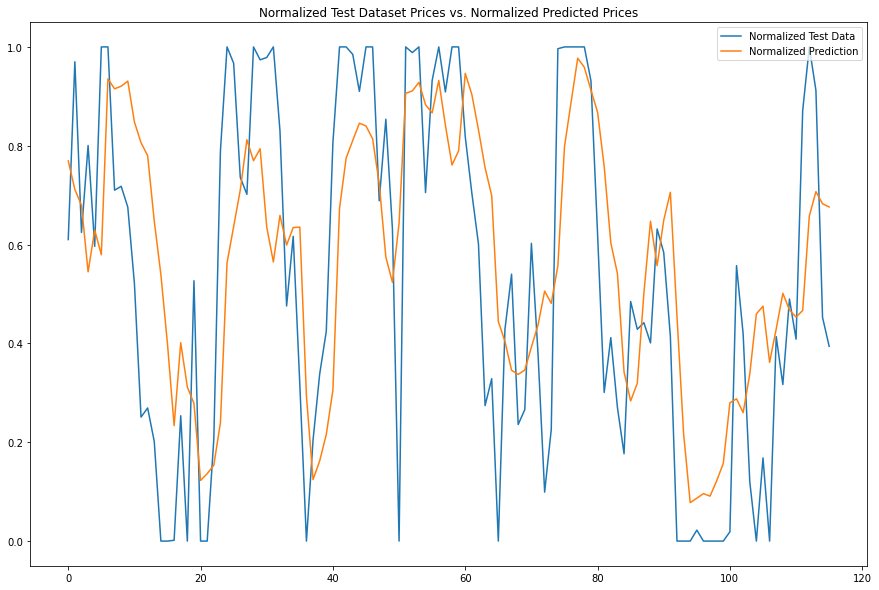

In [137]:
#Plot normalized results

plt.figure(figsize=(15,10))
plt.title('Normalized Test Dataset Prices vs. Normalized Predicted Prices')
plt.plot(y_test,label = 'Normalized Test Data')
plt.plot(Predict_AAPL, label = 'Normalized Prediction')
plt.legend(loc='best')
plt.show()

From this plot I can see the model can predict prices that follow the big trends.  Now let's revert the predicted data back to the original form to compare with the original test prices.

In [70]:
data=x_test
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=baseline_model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)

In [71]:
de_predicted_AAPL=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted_AAPL.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted_AAPL)

[114.55915579177903, 114.00017518889906, 113.69111387534055, 112.88942574204827, 115.11890413492203, 115.30874770254415, 123.66438729475726, 123.43506249399019, 123.49507383159934, 123.61205093465591, 122.69225465379468, 122.22088494787222, 122.325229732301, 121.07760341420939, 120.41459387963444, 118.77174665408415, 116.47680074163578, 117.50955633192793, 114.16354230240793, 113.37788748555664, 109.92176327126394, 109.96234536832401, 110.01387274524258, 110.64541659101758, 114.54896796626109, 115.3012414320297, 116.0593508601531, 117.10151198087334, 117.02115785985396, 117.28083579738112, 115.58000619964433, 116.00947113031161, 118.47595541148772, 118.5634582838555, 118.71740532926106, 118.7206998254548, 115.74100616337915, 114.65277873885944, 114.89624953360641, 115.24235018306112, 115.82050931820926, 119.82170578606531, 121.00455964683027, 121.33337558758909, 121.6551061327435, 122.16658604591838, 122.66834674106313, 122.06761301760353, 121.06733424705749, 121.84109422405889, 123.45

In [72]:
#Calculate MSE and accuracy

error = []
diff=y_test.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted_AAPL[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy=1-mean_error_percent

MSE=sum(squaredError) / len(squaredError)

print("MSE",MSE)
print('accuracy',accuracy)

MSE [5.79186714]
accuracy [0.98419591]


The descrepancy between this loss (MSE) compared with loss calculated during training indicates overfitting.  However, the goal of this study is to check if incorporating sentiment analysis data to training adds to the performance of an LSTM network model or takes away. 

In [73]:
# Let's visualize the results

data_frame = sentiment_df_AAPL
original = data_frame['Close'][0:data_frame.shape[0]-1]
predicted_data_AAPL = de_predicted_AAPL
print(len(original))
print(len(predicted_data_AAPL))

1255
116


In [74]:
x_label = np.arange(1140, 1256)
x_label

array([1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150,
       1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161,
       1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172,
       1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183,
       1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194,
       1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205,
       1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216,
       1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227,
       1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238,
       1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249,
       1250, 1251, 1252, 1253, 1254, 1255])

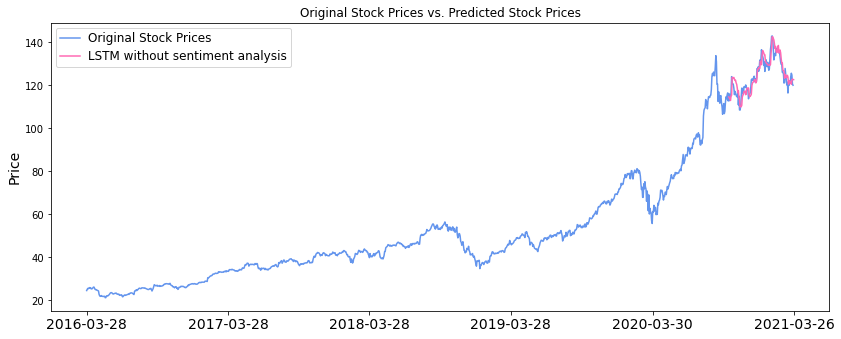

In [139]:
# Plot the entire time frame of interested with predicted test results 

fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,1
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Original Stock Prices vs. Predicted Stock Prices')

plt.plot(original,color="cornflowerblue",linestyle = "-",label="Original Stock Prices",linewidth=1.5)
plt.plot(x_label,predicted_data_AAPL,color="hotpink",linestyle = "-",label="LSTM without sentiment analysis",linewidth=1.5)

plt.ylabel("Price",fontsize=14)
   
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

x=np.array([0.,  251,  502, 753, 1005, 1256])
group_labels=['2016-03-28','2017-03-28','2018-03-28','2019-03-28', '2020-03-30','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

In [76]:
original_test = original[1139:1256]

[None, None, None, None]

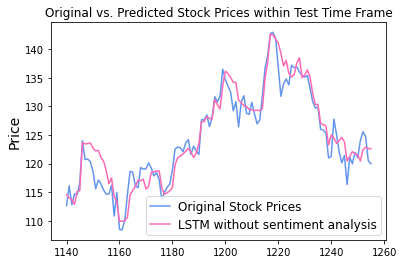

In [140]:
# Plot just the original close prices from the test dataset with the predicted prices

fig = plt.figure()
plt.title('Original vs. Predicted Stock Prices within Test Time Frame')

plt.plot(x_label,original_test,color="cornflowerblue",linestyle = "-",label="Original Stock Prices",linewidth=1.5)
plt.plot(x_label,predicted_data_AAPL,color="hotpink",linestyle = "-",label="LSTM without sentiment analysis",linewidth=1.5)

plt.ylabel("Price",fontsize=14)
   
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

---
# Stock Price Forecast With Sentiment Analysis

***7. Build and tune an LSTM model on AAPL's historical transaction data combined with sentiment data to predict AAPL stock prices.***

LSTM neural network is used to predict the stock price, the input data is the previous
stock price and the sentiment analysis results


In [32]:
# Hyperparameters

batch_size=100;
input_dim=4

# Only the input dimension is different to account for the new sentiment related features
input_timesteps=9
neurons=100
epochs=50
prediction_len=1
dense_output=1
drop_out=0.5

In [33]:
# LSTM MODEL (same architecture as for the baseline model)
sentiment_model = Sequential()

sentiment_model.add(LSTM(neurons, 
                        input_shape=(input_timesteps, input_dim), 
                        activation='tanh',return_sequences = True, name = 'LSTM_1'))

sentiment_model.add(Dropout(drop_out, name = 'Dropout_1'))

sentiment_model.add(LSTM(neurons,return_sequences = True, 
                        activation='tanh',name = 'LSTM_2'))

#only return the last hidden state output 
sentiment_model.add(LSTM(neurons,return_sequences =False, 
                        activation='tanh',name = 'LSTM_3'))
sentiment_model.add(Dropout(drop_out, name = 'Dropout_2'))

sentiment_model.add(Dense(dense_output, activation='linear', name = 'Dense_Output'))

sentiment_model.compile(loss='mean_squared_error',
                optimizer='adam')

sentiment_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 9, 100)            42000     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 9, 100)            0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 9, 100)            80400     
_________________________________________________________________
LSTM_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
Dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
Dense_Output (Dense)         (None, 1)                 101       
Total params: 202,901
Trainable params: 202,901
Non-trainable params: 0
__________________________________________________

In [34]:
early = EarlyStopping(monitor='val_loss', verbose=1, patience=5) 
# Fit the model
sentiment_model.fit(x_train_s,y_train_s,epochs=epochs,batch_size=batch_size, 
                    validation_data = (x_valid_s, y_valid_s), callbacks = early)

Epoch 1/50
11/11 [==============================] - 7s 54ms/step - loss: 0.3518 - val_loss: 0.1761
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 0.1639 - val_loss: 0.1451
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.1380 - val_loss: 0.1267
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0889 - val_loss: 0.2198
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0925 - val_loss: 0.1090
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0779 - val_loss: 0.1150
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0821 - val_loss: 0.1272
Epoch 8/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0834 - val_loss: 0.1587
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0790 - val_loss: 0.1612
Epoch 10/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0798 - val_loss: 0.1665
Epoch 00010: early

In [35]:
Predict_sentiment_AAPL = sentiment_model.predict(x_test_s,verbose =1)

4/4 [==============================] - 0s 2ms/step


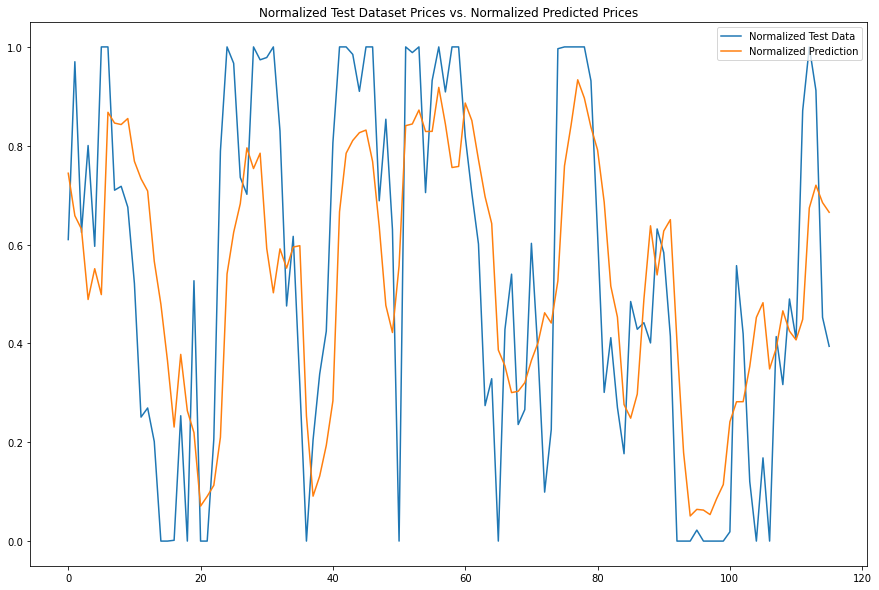

In [141]:
#Plot normalized results

plt.figure(figsize=(15,10))
plt.title('Normalized Test Dataset Prices vs. Normalized Predicted Prices')
plt.plot(y_test_s,label = 'Normalized Test Data')
plt.plot(Predict_sentiment_AAPL, label = 'Normalized Prediction')
plt.legend(loc='best')
plt.show()

In [37]:
# Revert predicted data to that comparable to original stock close prices

data=x_test_s
prediction_seqs = []
window_size=sequence_length
pre_win_num=int(len(data)/prediction_len)

for i in range(0,pre_win_num):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(0,prediction_len):
      temp=sentiment_model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)

In [38]:
de_predicted=[]
len_pre_win=int(len(data)/prediction_len)
len_pre=prediction_len

m=0
for i in range(0,len_pre_win):
    for j in range(0,len_pre):
      de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
      m=m+1
print(de_predicted)

[114.31799742993445, 113.48665227208795, 113.22476278922439, 112.40989044916245, 114.765925812567, 114.99018382704172, 122.89384261521325, 122.64625930410105, 122.61239308430349, 122.75134239649927, 121.79817080197982, 121.40137390689308, 121.65036246587232, 120.31044845182106, 119.89698738247215, 118.45544273690426, 116.45936022982103, 117.3634275866725, 113.70772135725734, 112.91635683095065, 109.47234258661227, 109.56158647625828, 109.68401960884675, 110.41586379128417, 114.3166907937191, 115.17973073936597, 115.77538661831775, 116.9340761844729, 116.85116652721236, 117.18407907940977, 115.11553203748322, 115.39428482689058, 118.11356946522744, 118.36177265944832, 118.54640923379188, 118.55824154656102, 115.4842745267459, 114.43662024978913, 114.69798230114097, 115.09944782087263, 115.68007522262909, 119.76071942089882, 121.09393994008838, 121.33253605705937, 121.47765930697761, 122.08386305956105, 122.24316064207501, 121.34714936447925, 120.30553632983012, 121.29963452807843, 123.2

In [39]:
# Calculate MSE and accuracy

error = []
diff=y_test_s.shape[0]-prediction_len*pre_win_num

for i in range(y_test_ori.shape[0]-diff):
    error.append(y_test_ori[i,] - de_predicted[i])
    
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val) 
    absError.append(abs(val))

error_percent=[]
for i in range(len(error)):
    val=absError[i]/y_test_ori[i,]
    val=abs(val)
    error_percent.append(val)

mean_error_percent=sum(error_percent) / len(error_percent)
accuracy_sentiment=1-mean_error_percent

MSE_sentiment=sum(squaredError) / len(squaredError)

print("MSE",MSE_sentiment)
print('accuracy',accuracy_sentiment)

MSE [5.2038426]
accuracy [0.98478501]


In [40]:
# Let's visualize the results from this test as well

data_frame = sentiment_df_AAPL
original = data_frame['Close'][0:data_frame.shape[0]-1]
predicted_data = de_predicted
print(len(original))
print(len(predicted_data))

1255
116


In [41]:
x_label = np.arange(1140, 1256)
x_label

array([1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150,
       1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161,
       1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172,
       1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183,
       1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194,
       1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205,
       1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216,
       1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227,
       1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238,
       1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249,
       1250, 1251, 1252, 1253, 1254, 1255])

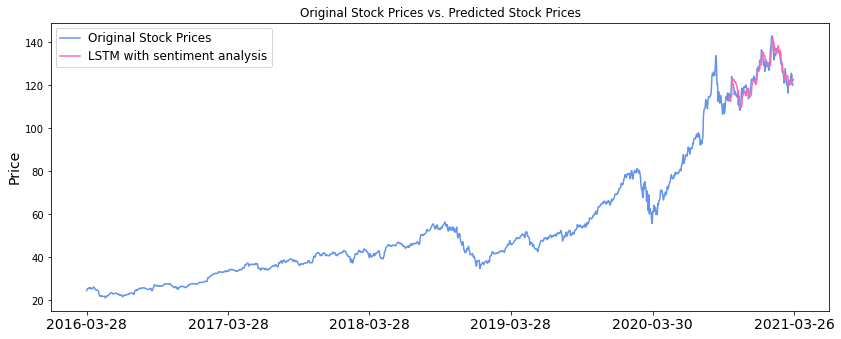

In [142]:
fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,1
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Original Stock Prices vs. Predicted Stock Prices')

plt.plot(original,color="cornflowerblue",linestyle = "-",label="Original Stock Prices",linewidth=1.5)
plt.plot(x_label,predicted_data,color="hotpink",linestyle = "-",label="LSTM with sentiment analysis",linewidth=1.5)

plt.ylabel("Price",fontsize=14)
   
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

x=np.array([0.,  251,  502, 753, 1005, 1256])
group_labels=['2016-03-28','2017-03-28','2018-03-28','2019-03-28', '2020-03-30','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

In [43]:
original_test = original[1139:1256]

[None, None, None, None]

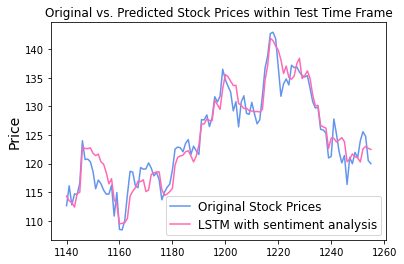

In [143]:
fig = plt.figure()
plt.title('Original vs. Predicted Stock Prices within Test Time Frame')

plt.plot(x_label,original_test,color="cornflowerblue",linestyle = "-",label="Original Stock Prices",linewidth=1.5)
plt.plot(x_label,predicted_data,color="hotpink",linestyle = "-",label="LSTM with sentiment analysis",linewidth=1.5)

plt.ylabel("Price",fontsize=14)
   
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

# Model Comparisons

***8. Compare mean squared error and accuracy between the two LSTM models (with and without sentiment analysis data)***

Without sentiment analysis:
- MSE [5.79186714]
- accuracy [0.98419591]

With sentiment analysis:
- MSE [5.2038426]
- accuracy [0.98478501]

In other words, **MSE was improved by 10.15%** with the addition of sentiment analysis for training the model, while the improvement on accuracy is 0.06%.

In [78]:
print('Without sentiment analysis the RMSE is: '+ str(sqrt(5.79186714)))
print('With sentiment analysis the RMSE is: '+ str(sqrt(5.2038426)))

Without sentiment analysis the RMSE is: 2.4066298302813416
With sentiment analysis the RMSE is: 2.2811932403897743


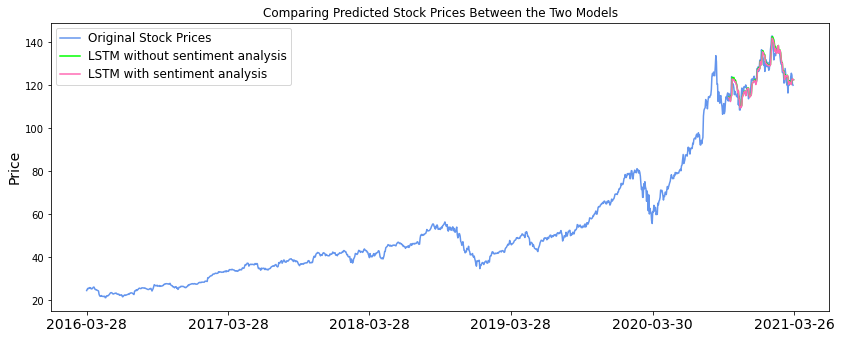

In [144]:
# Let's plot the predicted prices from both models with the original stock prices

fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,1
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Comparing Predicted Stock Prices Between the Two Models')

plt.plot(original,color="cornflowerblue",linestyle = "-",label="Original Stock Prices",linewidth=1.5)
plt.plot(x_label,predicted_data_AAPL,color="lime",linestyle = "-",label="LSTM without sentiment analysis",linewidth=1.5)
plt.plot(x_label,predicted_data,color="hotpink",linestyle = "-",label="LSTM with sentiment analysis",linewidth=1.5)

plt.ylabel("Price",fontsize=14)
   
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12) 

x=np.array([0.,  251,  502, 753, 1005, 1256])
group_labels=['2016-03-28','2017-03-28','2018-03-28','2019-03-28', '2020-03-30','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

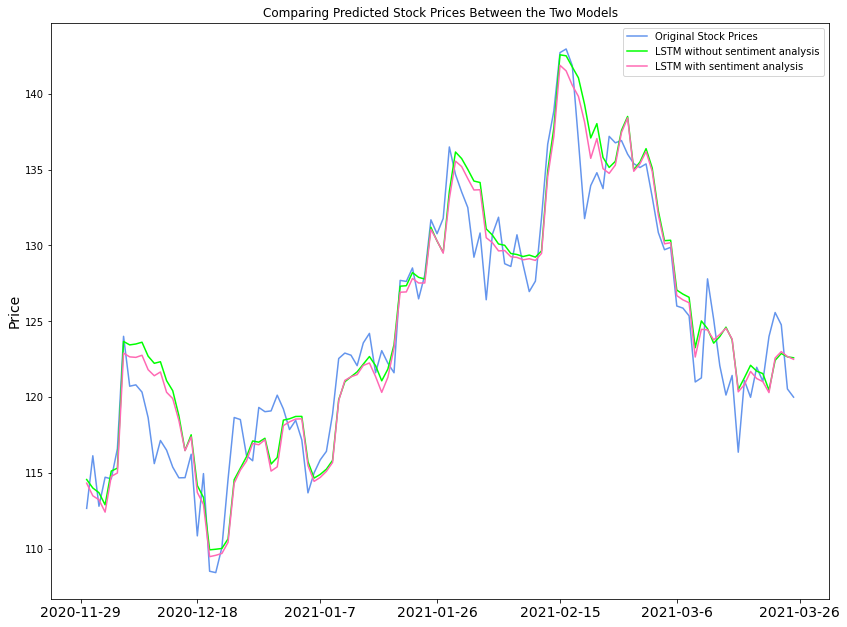

In [145]:
# Let's visualize the predicted and original prices within the test time frame only

fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,2
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Comparing Predicted Stock Prices Between the Two Models')

plt.plot(x_label,original_test,color="cornflowerblue",linestyle = "-",label="Original Stock Prices",linewidth=1.5)
plt.plot(x_label,predicted_data_AAPL,color="lime",linestyle = "-",label="LSTM without sentiment analysis",linewidth=1.5)
plt.plot(x_label,predicted_data,color="hotpink",linestyle = "-",label="LSTM with sentiment analysis",linewidth=1.5)

plt.ylabel("Price",fontsize=14)
   
plt.legend(loc=0, numpoints=1)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=10) 

x=np.array([1139, 1158, 1178, 1197, 1217, 1236, 1256])
group_labels=['2020-11-29','2020-12-18','2021-01-7','2021-01-26','2021-02-15', '2021-03-6','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

In [81]:
sentiment_scores_plot = data_frame['Sentiment_Mean'][0:data_frame.shape[0]-1]
sentiment_scores_plot = sentiment_scores_plot[1139:1256]

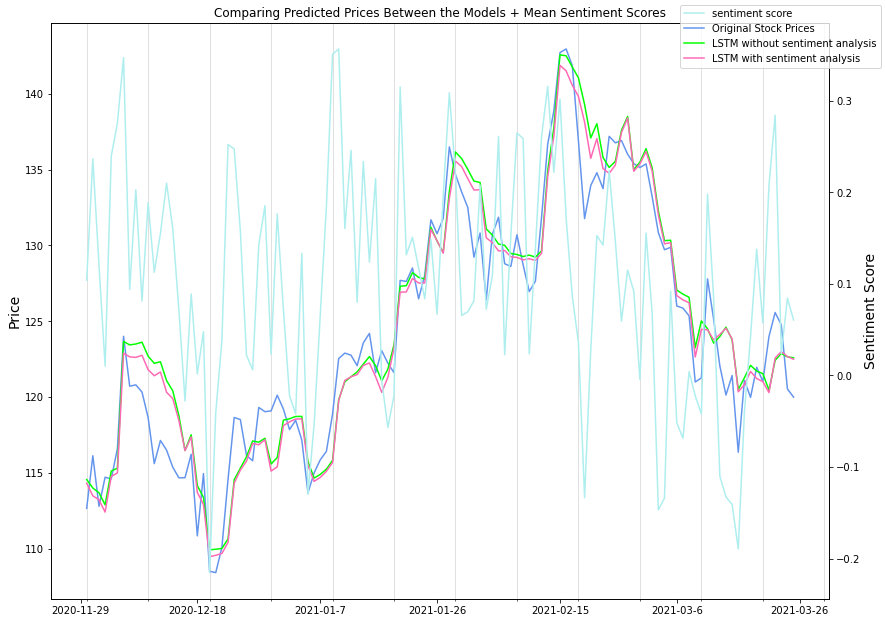

In [148]:
# Let's see an overlay of the mean sentiment score on the stock price plot (from above)

fig = plt.figure()
left, bottom, width, height = 0.1,0.1,1.8,2
ax1 = fig.add_axes([left,bottom,width,height])
plt.title('Comparing Predicted Prices Between the Models + Mean Sentiment Scores')

ax2 = ax1.twinx()

ln1 = ax2.plot(x_label,sentiment_scores_plot,color="paleturquoise",
               linestyle = "-",label="sentiment score",linewidth=1.5)
ln2 = ax1.plot(x_label,original_test,color="cornflowerblue",linestyle = "-",
               label="Original Stock Prices",linewidth=1.5)
ln3 = ax1.plot(x_label,predicted_data_AAPL,color="lime",linestyle = "-",
               label="LSTM without sentiment analysis",linewidth=1.5)
ln4 = ax1.plot(x_label,predicted_data,color="hotpink",linestyle = "-",
               label="LSTM with sentiment analysis",linewidth=1.5)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
fig.legend(lns, labs, loc='upper right')

ax1.set_ylabel("Price",fontsize=14)
ax2.set_ylabel("Sentiment Score",fontsize=14)
   
#plt.legend(loc=0, numpoints=1)
#leg = plt.gca().get_legend()
ml = MultipleLocator(10)
ax1.xaxis.set_minor_locator(ml)
ax1.xaxis.grid(which="minor", color='lightgrey', linestyle='-', linewidth=0.7)
#ltext = leg.get_texts()
plt.setp(ltext, fontsize=10) 

x=np.array([1139, 1158, 1178, 1197, 1217, 1236, 1256])
group_labels=['2020-11-29','2020-12-18','2021-01-7','2021-01-26','2021-02-15', '2021-03-6','2021-03-26']
plt.xticks(x,group_labels,fontsize=14,)
plt.show(block=False)

It is exciting to see that the then trends from the mean sentiment scores seem to correlate with the stock price trends. ie. with positive sentiment the trend for stock prices is up, with negative the prices go down.  

---

# Conclusion

The MSE scored improved by 10.15% predicting stock prices with sentiment analysis compared to without (just the LSTM model trained on closing prices). Both models have high accuracy scores (around 98%), however, it is more meaningful to compare MSE scores rather than accuracy (which is more for classification problems). I would say I achieved my goal of determining if it is better or not to utilize sentiment analysis data in predicting stock prices using Apple Inc.'s stocks as an example.  As it turns out, it is better by around 10%.  

Moving on, I believe the stock price forecasting model might be a lot better if I could get my hands on more fine-grained historical stock transaction data. 

I tried training the models on variable combinations of high, low, open, volume values, which were available in the kaggle dataset. I also attempted variable combinations of the sentiment score data I collected with the stock historical transaction data.  The best performance I found can be seen in this notebook ie. just close prices, mean sentiment, median sentiment, and standard deviation of sentiment scores. 

Perhaps having the stock price data for each minute or hour combined with average sentiment scores from each minute or hour might yield better results after training the model. The main problem is I did not come across such a dataset during my search.  

**Summary of Major Challenges Faced**
- Collecting all the content for sentiments analysis
- Finding a good NLP model to implement (had to do a bit of digging to eventually uncover FinBERT and learn how to implement it)
- Ensuring the text data corresponds with the relevant trading day (the large cell I made to do that and run FinBERT as well as other processing steps was a challenge to figure out, but I am happy with the result).
- Figuring out the best way to clean and prepare the datasets for training including which features to focus on (I tried many combinations of datasets)
- Researching and deciding on the architecture for the LSTM model (I also attempted many different forms of the model based on class notes and research)

At the end, I gained several python notebooks for this project with varying datasets and models. 

**Future Studies**

Towards the end of my project I had the chance to attend a machine learning summit involving finance.  It was interesting to see that there were no presenters talking about utilizing sentiment analysis for stock forecast. Nevertheless, JP Morgan used sentiment analysis to determine which candidate would win the U.S. presidential election in the interest of their investors.  It turns out analyzing sentiment on Twitter yielded better results than public polls to predict who would win.  

As for stock forecasting, I saw several projects related to that and they utilized variational autoencoders (VAEs) or generational adversarial networks (GANs) to simulate the market.  I thought that was very interesting and came across a neat paper: [A Data-Drive Market Simulator for Small Data Environments](https://arxiv.org/pdf/2006.14498.pdf)

I also saw another study where they examined a variety of graphical models - including PCA-KMeans, VAEs, and dynamic clustering - to construct optimal portfolios.

I think that would be a very interesting to research into those modes for future studies involving stock price forecasting with the addition of sentiment analysis data.  
 


---
Overall, it was challenging and rewarding to have learned so much about NLP and RNN as well as the numerous other neural networks during this course.  

## *Thank you for the excellent course and thank you for reading ~*